# Creating Dot Density Maps with Census Data

The [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) is probably the most common way of visualizing data variation over geographic space. In a choropleth map, areas are shaded proportional to their value, providing an easy way of identifying variability within a region. Below, is an example, of a choropleth map showing median household income by Census Tract in Alameda County, CA.

![img](Alameda_County_Choropleth4.png)

However, certain types of data (especially those which continously vary in concentration over space), can often be more clearly presented in the form of a [dot density map](https://en.wikipedia.org/wiki/Dot_distribution_map). Dot density maps rely on a visual scattering of points to show spatial patterns that represent concentrations of subjects within a given area. The data for a dot density map can be modeled using a randomized point-in-polygon algorithm that generates a number of points proportional to the value of interest.

The purpose of this post is two-fold:
1. Demonstrate how to extract Census data (both geographic boundaries and demographic data). In a [previous post](http://andrewgaidus.com/Reading_Zipped_Shapefiles/) I used Python to read geographic data from a website URL directly into memory. In this post, I will use this in conjunction with the Census API to extract data that can be matched to these geographies.

2. Demonstrate how geospatial tools in Python can be used to create dot density maps from scratch.

Ultimately, I will use these tools to create a set of figures that provide an easy way to visualize population distributions within a county by race and ethnicity.  

In this post, I will focus less on the programming specifics and more on the general concepts and figures. For the purpose of this exercise, I wrote a Python module called ```census mapper``` that contains the functions that I use for (1) extracting census geographic and demographic data, (2) implementing the random point in polygon algorithm needed to create a dot-density map, and (3) actually plotting the data. The [code](https://github.com/agaidus/census_data_extraction/blob/master/census_mapper.py) for these functions can be found on my [GitHub](https://github.com/agaidus/census_data_extraction). 

Note that I will be working with the Census data at the block group level, because this is the most finely-grained geography for which demographic data is available. As a size reference, block groups are defined to have between 600 and 3,000 people. Also, I will be using the [2015 American Community Survey](https://www.census.gov/programs-surveys/acs/) (ACS) 5-Year Averages as my Census Demographic data source. The ACS is an ongoing survey that provides data estimates between the Decennial Census. The 2015 5-Year Averages are the most current data that can be obtained at the block group level. 


In [1]:
from census_mapper import *
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
%matplotlib inline

## 1 - Read in Block Group Geography within a County
The details of the code behind this function are described in an earlier [post](http://andrewgaidus.com/Reading_Zipped_Shapefiles/), but here I just demonstrate its use with a quick example. I provide the Census FTP address for the Shapefile of California Census Tracts and I return a ```GeoDataframe```. I subset this data to include only Alameda County and then reproject it to a new coordinate reference system.

In [2]:
zipped_shp_url = 'http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_06_tract_500k.zip'

all_ca_tract_geo = zip_shp_to_gdf(zipped_shp_url)
alameda_tract_geo = all_ca_tract_geo[all_ca_tract_geo.COUNTYFP=='001']
alameda_tract_geo = alameda_tract_geo.set_index("GEOID")['geometry'].to_crs(epsg=3310)
print(alameda_tract_geo.head())

GEOID
06001400600    POLYGON ((-199300.688 -16762.192, -199042.225 ...
06001400900    POLYGON ((-200850.363 -17209.575, -200637.164 ...
06001401400    POLYGON ((-200272.878 -18657.947, -199396.328 ...
06001403000    POLYGON ((-200009.001 -21782.858, -199688.094 ...
06001405902    POLYGON ((-197607.799 -22832.022, -197278.871 ...
Name: geometry, dtype: geometry


## 2 - Get ACS Demographic Data
Now that I have my geography, I need some demographic data to match it to. While I ultimately will be using population counts, in this example I extract the variable for Median Household Income. I specify the specific dataset I want (2015, ACS, Census Tracts); the geographic extent of my data (Alameda County, which is FIPS 06001); and the set of variables that I'm interested in (median household income, which is ACS variable B19013_001E. The full set of variable names and descriptions available from the census can be found [here](http://api.census.gov/data/2015/acs5/variables.html). 

This function then returns a DataFrame indexed by Tract FIPS that contains my specified variables. Note that I also specified an optional variable label parameter, which is just used to rename its default name to something more useful.

In [3]:
alameda_tract_income = get_census_variables(2015, 'acs5', 'tract', 
                                            {'county':'001', 'state':'06'}, 
                                            ['B19013_001E'], ['income'])['income'].dropna().astype(int)
alameda_tract_income.head()

https://api.census.gov/data/2015/acs/acs5 {'get': 'NAME,B19013_001E', 'for': 'tract:*', 'in': 'county:001+state:06'}


FIPS
06001422300     57667
06001422400     54554
06001422500     54063
06001422600    250001
06001422700     27090
Name: income, dtype: int64

Having both the data and the geographic information, I can make a choropleth map of income level using the ```GeoPandas``` built in plotting functions. If you are familiar with the Bay Area, you'll see that the map shows a pattern we might expect - wealthier populations tend to live in the Oakland / Berkeley Hills and the suburbs.

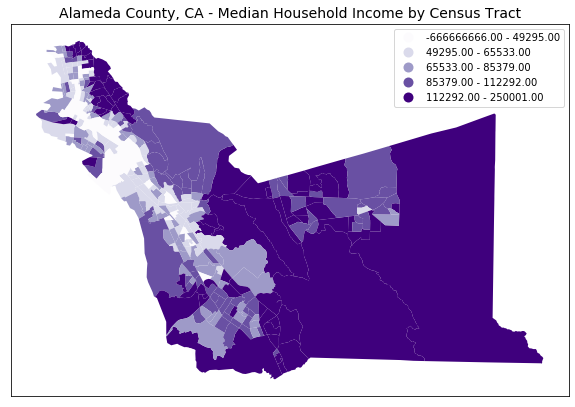

In [4]:
alameda_gdf = gpd.GeoDataFrame(geometry = alameda_tract_geo, data = alameda_tract_income)
fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal', xticks=[], yticks=[])
alameda_gdf.plot(column= 'income', ax = ax, scheme='QUANTILES', cmap='Purples', legend=True)
plt.title('Alameda County, CA - Median Household Income by Census Tract', size = 14)
plt.savefig('Alameda_County_Choropleth4.png',bbox_inches='tight',dpi=100)

## 3 -  Randomly Generating Points within Polygons
Now we're ready to turn to the dot-density functions. The ```census_mapper``` script contains a function called ```gen_points_in_gdf_polys```, which is used to create the points that will be plotted in the maps. Below, I demonstrate its functionality with a simple example. Let's say I have the following 3 polygons in my dataset, each of which has a different (specified) number of people living in it. 

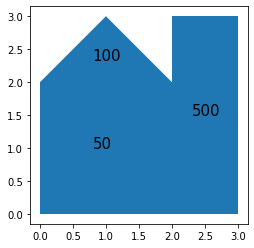

In [5]:
p1 = Polygon([[0,2],[1,3],[2,2]])
p2 = Polygon([[0,0],[0,2],[2,2],[2,0]])
p3 = Polygon([[2,0],[2,3],[3,3],[3,0]])
g = gpd.GeoSeries([p1,p2,p3])

vals = pd.Series([100, 50, 500])

ax = g.plot()
for label,loc in zip(vals, g.centroid):
    ax.text(loc.x-.2, loc.y, str(label), fontsize=15)


I want to randomly generate 100 points in the red triangle, 50 points in the orange square, and 500 points in the grey rectangle. My function works by randomly generating a point within the minimum bounds of a polygon, checking that it actually falls within the polygon, and then adding it to a list if it does. This is repeated until the necessary number of points is generated. The function is then applied over the entire dataset of Polygons and values.

Below, I plot the output points, which make it really easy to compare these fictional polygon densities.

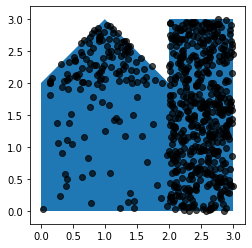

In [6]:
random_points = gen_points_in_gdf_polys(geometry = g, values=vals)

ax = g.plot()
random_points.plot(color='black', ax=ax, alpha=.7)

## 4 - Create Dot Density Maps

Now that we have our tools to extract the data and generate the dot-density points, we're ready to create some maps with real data. The function ```gen_count_dot_density_map``` wraps the other functions I defined above. The only required input is an identification of the county that will be mapped. This can be specified either by county fips or by the county name.

The function then reads in the county's block group geography and block group population counts by race / ethnicity. Then points are randomly scattered within each block group proportional to that block group's population data in 5 different race categories: White, Black, Hispanic, Asian, and Other. Note that 'Other' is composed of American Indian / Alaskan Native, Native Hawaiian / Pacific Islander, Multiracial, and any other race. There is an optional parameter ```pts_per_person```, which defines the ratio of dots per capita. Otherwise, this defaults to 300 dots per person.

The function then returns a labeled map of point densities colored by race and overlayed on top of county boundaries. The function also takes optional parameters related to plotting appearance, as well as an EPSG code for the output map projection. This parameter defaults to EPSG: 2163 (US National Atlas Equal Area).

### County Examples

I will now call this function on several counties across the U.S. that contain major cities as a way to compare population patterns. 

Alameda County appears to be pretty diverse although there are certainly patterns to the population distributions. In general, most of the county's population is in the eastern part of the county, which runs from Berkeley down to Fremont. The western part of the county has the large suburbs of Pleasanton and Livermore, which is separated from the eastern part of the city by hilly open space.

Looking by race we see that there are definite clusters. The white population is largely located in Berkeley and in the hills above Oakland; the Black population is primarily in West Oakland and East Oakland; the Hispanic population is mostly in the San Leandro / Hayward area; and the Asian population is pretty spread out with a pretty large population near Union City and Fremont as well as clusters in Oakland and Berkeley.

https://api.census.gov/data/2015/acs/acs5 {'get': 'NAME,B03002_003E,B03002_012E,B03002_004E,B03002_006E,B03002_005E,B03002_007E,B03002_008E,B03002_009E', 'for': 'block group:*', 'in': 'county:037+state:06'}


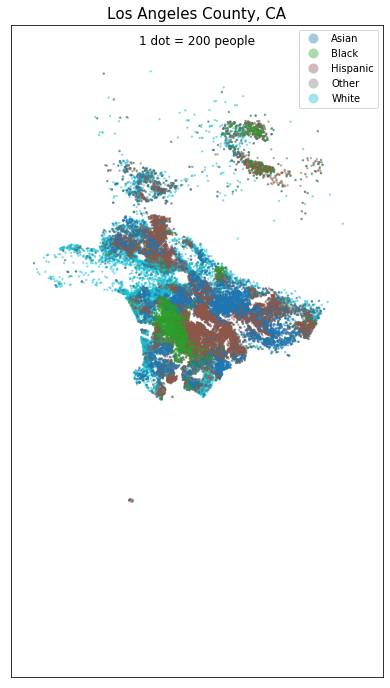

In [16]:
gen_count_dot_density_map('Los Angeles County, CA', pts_per_person=200)

Perhaps even more interesting is Cook County, IL, which contains Chicago. Chicago is [known](https://fivethirtyeight.com/features/the-most-diverse-cities-are-often-the-most-segregated/) for being one of the most diverse, but also one of the most racially segregated cities in the country. This map makes that point very clearly. I am not familiar enough with Chicago's neighborhoods to describe this map, but it is very clear that they vary in terms of their racial composition.




https://api.census.gov/data/2015/acs/acs5 {'get': 'NAME,B03002_003E,B03002_012E,B03002_004E,B03002_006E,B03002_005E,B03002_007E,B03002_008E,B03002_009E', 'for': 'block group:*', 'in': 'county:031+state:17'}


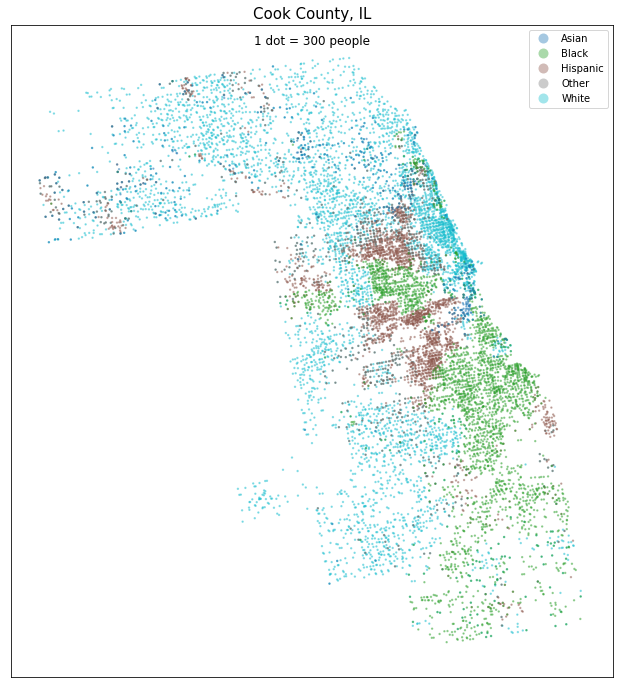

In [8]:
gen_count_dot_density_map('Cook County, IL')

New York City is another one that I'm a bit more familiar with, and as you can see it too has clear population patterns. The northern part of Manhattan around Washington Heights and Inwood is largely Hispanic; Harlem is primarily a Black neighborhood; the Upper East and West Sides (around Central Park) are primarily White; and there is a large Asian population around Chinatown.

https://api.census.gov/data/2015/acs/acs5 {'get': 'NAME,B03002_003E,B03002_012E,B03002_004E,B03002_006E,B03002_005E,B03002_007E,B03002_008E,B03002_009E', 'for': 'block group:*', 'in': 'county:061+state:36'}


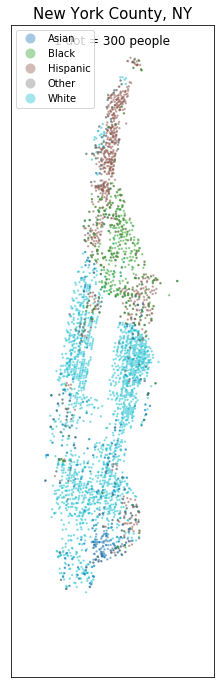

In [9]:
gen_count_dot_density_map('New York County, NY')

Brooklyn too appears to have very clustered population groups.

https://api.census.gov/data/2015/acs/acs5 {'get': 'NAME,B03002_003E,B03002_012E,B03002_004E,B03002_006E,B03002_005E,B03002_007E,B03002_008E,B03002_009E', 'for': 'block group:*', 'in': 'county:047+state:36'}


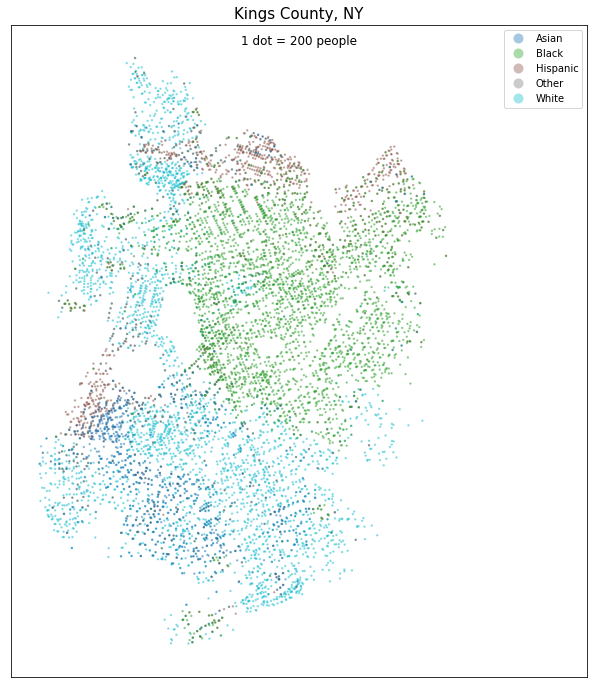

In [10]:
gen_count_dot_density_map('Kings County, NY', pts_per_person=200)

And lastly, I plot Denver, which appears to have a relatively large Hispanic population that is located mainly in the western part of the city.

https://api.census.gov/data/2015/acs/acs5 {'get': 'NAME,B03002_003E,B03002_012E,B03002_004E,B03002_006E,B03002_005E,B03002_007E,B03002_008E,B03002_009E', 'for': 'block group:*', 'in': 'county:031+state:08'}


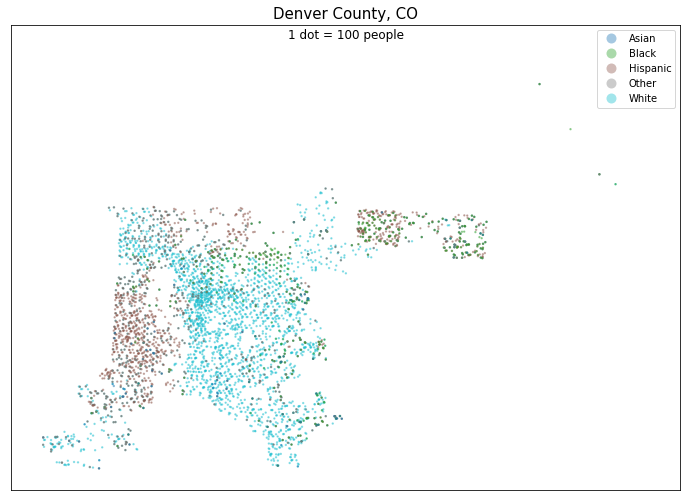

In [11]:
gen_count_dot_density_map('Denver County, CO', pts_per_person=100)